In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions for Analysis
*Scroll down to 'Load and Visualize Data' for Primary Functions*

In [2]:
# Input: 
#      row (row of the column summary datframe)
# Output: 
#      returns a tuple if continuous, otherwise the list of categoricals
def get_continuous_min_max(row):
    #print row
    if row['predictor_type'] == 'Continuous':
        value_range = np.array([value for value in row['value_range'] if str(value) != 'nan'])
        return (value_range.min(), value_range.max())
    else:
        return row['value_range']
    
#--------  get_column_summary
# A function that creates a dataframe summarizing the shape and composition of the data within each column
# Input: 
#      df (dataframe to get column summary for)
# Output: 
#      df_column_summary (dataframe with various components of each column)
def get_column_summary(df):
    # Create a dataframe of unique values, # of missing values, type, and value type for each predictor
    df_column_summary = pd.DataFrame({})
    df_column_summary['column_name'] = df.columns.values
    df_column_summary['value_range'] = df_column_summary['column_name'].apply(lambda row: [value for value in df[row].unique() if value == value])
    df_column_summary['null_values'] = df_column_summary['column_name'].apply(lambda row: df[row].isnull().sum())
    df_column_summary['predictor_type'] = df_column_summary['column_name'].apply(lambda row: 'Categorical' if df[row].dtype == 'object' else 'Continuous')
    df_column_summary['value_type'] = df_column_summary['column_name'].apply(lambda row: df[row].dtype)
    df_column_summary['value_range'] = df_column_summary.apply(lambda row: get_continuous_min_max(row), axis = 1)
    return df_column_summary

In [3]:
#--------  encode_variables
# A function that encodes categorical variables
# Input: 
#      df (dataframe to encode variables for)
#      column_summary (dataframe summarizing the values for the columns in df)
# Output: 
#      df (dataframe with encoded variables)
def encode_variables(df, column_summary):
    variables_to_encode = []
    
    # loop through all of the columns in the dataframe and encode if categorical
    for column in df.columns.values:
        
        # check if variable is categorical
        if column_summary[column_summary['column_name'] == column]['predictor_type'].values[0] == 'Categorical':
            
            #get the first categorical value
            categorical_value = column_summary[column_summary['column_name'] == column]['value_range'].values[0][0]
            
            # if the variable is already binary, do not create a dummy variable, just encode numerically
            if categorical_value == True or categorical_value == False:
                df[column] = preprocessing.LabelEncoder().fit_transform(df[column])
            else:
                one_hot = pd.get_dummies(df[column])
                df = df.drop(column, axis = 1)
                df = df.join(one_hot)
        
    return df

In [4]:
#--------  ridge_lasso_cv
# A function that tunes the regularization parameter for ridge and lasso regression using k-fold cross-validation
# Input: 
#      x (predictor set)
#      y (outcome_set)
#      ridge_lasso (string indicating ridge or lasso regression)
# Output: 
#      (table and graph of model performance by regularization paramter)
def ridge_lasso_cv(x, y, ridge_lasso):
    
    # create a list of regularization parameters to use
    lambda_min = -7
    lambda_max = 7

    num_lambdas = 15
    lambdas = np.linspace(lambda_min, lambda_max, num_lambdas)
    
    # initalize array to store scores
    scores = np.zeros((num_lambdas, 3))
    
    # initialize k-folds to iterate through
    kf = KFold(x.shape[0], n_folds=7, shuffle=True)
    
    # loop through models using each regularization parameter in the list
    for i, lmbda in enumerate(lambdas):
        
        # initialize ridge or lasso model
        model = Ridge(alpha = 10.0**lmbda) if ridge_lasso == 'ridge' else Lasso(alpha = 10.0**lmbda)
        individual_train_scores = []
        individual_test_scores = []
        
        # fit and score the model on each fold
        for train_index, test_index in kf:

            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(x_train, y_train)
            
            train_score = model.score(x_train, y_train)
            individual_train_scores.append(train_score)
            
            test_score = model.score(x_test, y_test)
            individual_test_scores.append(test_score)

        # store the average model score for the regularization parameter in the array
        scores[i, 0] = lmbda
        scores[i, 1] = np.mean(individual_train_scores)
        scores[i, 2] = np.mean(individual_test_scores)
        
        # print the average test score for the regularization parameter
        print 'Regularization Parameter: 10^{0}; Score:{1:.4f}'.format(lmbda, np.mean(individual_test_scores))
    
    # plot the training and testing R^2s as a function of the regularization parameter
    plt.figure(figsize=(10,10))
    plt.semilogx([10**i for i in scores[:, 0]], scores[:, 1], 'r', label = 'training')
    plt.semilogx([10**i for i in scores[:, 0]], scores[:, 2], 'b', label = 'testing')
    plt.title('Ridge Regression Tuning Parameter Cross Validation')
    plt.xlabel('Regularization Parameter')
    plt.ylabel('R^2')  
    plt.legend(loc='best')
    plt.show()

In [5]:
#--------  rf_cv
# A function that tunes the max subset of predictors for a random forest model using k-fold cross-validation
# Input: 
#      x (predictor set)
#      y (outcome_set)
# Output: 
#      scores (array of both train and test scores for each subset of features)
def rf_cv(x, y):
    
    # initialize a list of the subset of predictors, with the max as one less predictor than the total number of predictors
    max_features = range(1, x.shape[1] + 1)
    
    # initalize array to store scores
    scores = np.zeros((x.shape[1] + 1, 3))
    
    # initialize k-folds to iterate through
    kf = KFold(x.shape[0], n_folds=7, shuffle=True)
    
    # loop through models using each subset of predictors in the list
    for i, feature in enumerate(max_features):
        
        # initialize random forest model
        rf = RandomForestRegressor(max_features = feature, n_estimators = 500)
        
        individual_train_scores = []
        individual_test_scores = []
        
        # fit and score the model on each fold
        for train_index, test_index in kf:

            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            rf.fit(x_train, y_train)
            
            train_score = rf.score(x_train, y_train)
            individual_train_scores.append(train_score)
            
            test_score = rf.score(x_test, y_test)
            individual_test_scores.append(test_score)

        # store the average model score for the regularization parameter in the array
        scores[i, 0] = feature
        scores[i, 1] = np.mean(individual_train_scores)
        scores[i, 2] = np.mean(individual_test_scores)
        
        # print the average test score for the max subset of predictors
        print 'Features:{0}; Score:{1:.4f}'.format(feature, np.mean(individual_test_scores))
        
    return scores

In [6]:
#--------  boosting_cv
# A function that tunes the number of trees and learning rate for a boosting model using k-fold cross-validation
# Input: 
#      x (predictor set)
#      y (outcome_set)
# Output: 
#      scores (array of both train and test scores for each subset of features)
def boosting_cv(x, y):
    
    # initialize a list of number of trees and learning rates for cv
    trees_validate = [10, 50, 100, 200]
    learning_rates = [.001, .01, .1, .5, 1]
    
    # initialize list to store scores
    scores = []
    
     # initialize k-folds to iterate throughs
    kf = KFold(x.shape[0], n_folds=7, shuffle=True)

    # loop through each number of trees in the validation list
    for trees in trees_validate:
        
        # loop through each learning rate in the validation list 
        for rate in learning_rates:

            boosting = AdaBoostRegressor(n_estimators = trees, learning_rate = rate)

            for train_index, test_index in kf:

                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]

                boosting.fit(x_train, y_train)
                score = boosting.score(x_test, y_test)
                scores.append(score)

            print 'Trees:{0}; Learning Rate:{1}; Score:{2:.4f}'.format(trees, rate, np.mean(scores))

In [7]:
# this entire code block allows for the encoded boruough predictors to be reversed for use in tableau visualizations

boroughs = ['Bronx', 'Brooklyn', 'New York','Queens', 'Staten Island']

#--------  get_borough
# A function that returns the borough for a record based on it's encoding
# Input: 
#      row (record in a dataframe)
# Output: 
#      borough (name of the borough)
def get_borough(row):
    for borough in boroughs:
        if row[borough] == 1:
            return borough

#--------  reencode_borough
# A function that creates a new dataframe column with the borough's name based on encoding
# Input: 
#      df (dataframe to create column for)
#      borough_array (array of boroughs with one hot encoding)
# Output: 
#      df (dataframe with a column holding borough names)
def reencode_borough(df, borough_array):
    df_boroughs = pd.DataFrame(borough_array, columns = boroughs)
    df['Borough'] = df_boroughs.apply(lambda row: get_borough(row), axis = 1)
    return df

In [8]:
#--------  get_price_residuals
# A function that calculates the standard price residuals for a model
# Input: 
#      model (sklearn model that has already been fit to a set)
#      x (array of predictors)
#      y (array of outcomes to compare predictions to)
#      log (binary indicating whether or not the outcome variable is a log transformation)
# Output: 
#      residual_std (standardized price residual)
def get_price_residuals(model, x, y, log):
    y_pred = model.predict(x)
    if log: # if the variable is a log transformation, first convert it back
        y_pred = np.exp(y_pred)
    residual = y_pred - y
    residual_std = residual / y
    return y_pred, residual_std

In [9]:
#--------  get_residual_df
# A function that creates a dataframe with predictors, outcomes, and residuals
# Input: 
#      model (sklearn model that has already been fit to a set)
#      x (array of predictors, excluding encoded boroughs)
#      boroughs (array of encoded boroughs)
#      y (array of outcomes to compare predictions to)
#      y_pred (array of predicted outcomes)
#      residuals (array of residuals)
#      column_names (list of predictor names, excluding boroughs)
# Output: 
#      df (dataframe holding predictors, outcomes, and residuals)
def get_residual_df(x, boroughs, y, y_pred, residuals, column_names):
    data = np.concatenate((x, y.reshape(-1, 1), y_pred.reshape(-1, 1),
                                      residuals.reshape(-1,1)), axis = 1)
    column_names = list(column_names) + ['price', 'price_pred', 'residual']
    df = pd.DataFrame(data, columns = column_names)
    df = reencode_borough(df, boroughs)
    return df

In [10]:
#--------  model_data_to_excel
# A function that writes a dataframe with predictors, outcomes, and residuals to excel
# Input: 
#      model (sklearn model that has already been fit to a set)
#      x_pred (array of predictors used to fit the model)
#      x (array of predictors for all models)
#      y (array of outcomes)
#      log (binary indicating whether or not the outcome variable is a log transformation)
#      df_full (dataframe containing both predictors and outcomes)
#      filename (name of the file to save to)
def model_data_to_excel(model, x_pred, x, y, log, df_full, filename):
    y_pred, residuals = get_price_residuals(model, x_pred, y, log)
    df = get_residual_df(x[:, :18], x[:, 18:], y, y_pred, residuals, df_full.columns.values[1:19])
    df.to_excel('rent_visualization_data/{0}.xlsx'.format(filename))

# Load and Visualize Data

In [11]:
# load the dataset
df_rent_clean = pd.read_csv('rent_clean_dataset.csv')

In [12]:
# get a summary of all predictors in the dataset
column_summary = get_column_summary(df_rent_clean)
column_summary

,column_name,value_range,null_values,predictor_type,value_type
0,Unnamed: 0,"(0, 12754)",0,Continuous,int64
1,Address,"[15 Park Row #11D, 15 Park Row #20D, 15 Park R...",0,Categorical,object
2,Baths,"(1.0, 11.0)",7,Continuous,float64
3,Beds,"(1.0, 8.0)",656,Continuous,float64
4,Bike Room,"[False, True]",1002,Categorical,object
5,Building Class,"[RM, D5, D2, D8, D7, R1, L9, C7, RX, S4, K4, C...",1068,Categorical,object
6,Built Year,"(1836, 2016)",0,Continuous,int64
7,Cats Only - No Dogs,"[False, True]",2085,Categorical,object
8,Cats and Dogs Allowed,"[False, True]",2085,Categorical,object
9,Children's Playroom,"[False, True]",1002,Categorical,object


# Variable Selection

In [13]:
# choose columns to use in models and drop records with null values
columns_to_use = ['Price', 'Beds', 'Baths', 'Sqft', 'Stories', 'Units', 'age', 'Borough',
                  'latitude', 'longitude', 'SchoolScore', 'std_crime', 'travel_minutes', 'travel_km',
                  'central_park_border_km', 'washington_sq_km', 'tompkins_sq_km',
                  'travel_minutes_grand_central', 'travel_km_grand_central', 'Sqft_sq']
df_for_model = df_rent_clean[columns_to_use].dropna()
print df_for_model.shape

# encode categorical variables and get the column summary to confirm
df_for_model = encode_variables(df_for_model, column_summary)
print df_for_model.shape
column_summary = get_column_summary(df_for_model)
column_summary.to_csv('model_variable_summary.csv')
column_summary

(4737, 20)
(4737, 24)


,column_name,value_range,null_values,predictor_type,value_type
0,Price,"(1200, 100000)",0,Continuous,int64
1,Beds,"(1.0, 8.0)",0,Continuous,float64
2,Baths,"(1.0, 11.0)",0,Continuous,float64
3,Sqft,"(300.0, 12173.0)",0,Continuous,float64
4,Stories,"(1, 96)",0,Continuous,int64
5,Units,"(1, 904)",0,Continuous,int64
6,age,"(0, 180)",0,Continuous,int64
7,latitude,"(40.503841, 40.90861)",0,Continuous,float64
8,longitude,"(-74.2448217, -73.7077149)",0,Continuous,float64
9,SchoolScore,"(-1.3828, 2.397)",0,Continuous,float64


In [14]:
# create numpy arrays from dataframe for use in models
values = df_for_model.values
x = values[:, 1:]
y = values[:, 0]

In [15]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# create arrays of the natural log of the price
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Base Model

*Base Model - Price*

In [16]:
# fit and score linear regression model using square feet as the only predictor
x_train_base = x_train[:, 2].reshape(-1, 1)
x_test_base = x_test[:, 2].reshape(-1, 1)
LinReg = LinearRegression()
LinReg.fit(x_train_base, y_train)

print 'Train Score: {0:.4f}'.format(LinReg.score(x_train_base, y_train))
print 'Test Score: {0:.4f}'.format(LinReg.score(x_test_base, y_test))

Train Score: 0.6817
Test Score: 0.5842


In [17]:
# write data to excel for tableau visualizations
model_data_to_excel(LinReg, x_train_base, x_train, y_train, False, df_for_model, 'base_train_no_log')
model_data_to_excel(LinReg, x_test_base, x_test, y_test, False, df_for_model, 'base_test_no_log')

*Base Model - Log Price*

In [18]:
# fit and score regression model using the log of square feet as the only predictor
# note that the we convert predictions back to the actual price before calculating the r2
LinRegLog = LinearRegression()
LinRegLog.fit(x_train_base, y_train_log)

print 'Train Score: {0:.4f}'.format(r2_score(y_train, np.exp(LinRegLog.predict(x_train_base))))
print 'Test Score: {0:.4f}'.format(r2_score(y_test, np.exp(LinRegLog.predict(x_test_base))))

Train Score: -70.4547
Test Score: -44.1205


In [19]:
# write data to excel for tableau visualizations
model_data_to_excel(LinRegLog, x_train_base, x_train, y_train_log, True, df_for_model, 'base_train_log')
model_data_to_excel(LinRegLog, x_test_base, x_test, y_test_log, True, df_for_model, 'base_test_log')

# Ridge Regression

In [20]:
# standardize variables for ridge and lasso regressions
scaler = StandardScaler(with_mean = False)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = x_test / scaler.scale_

*Ridge Regression - Price*

Regularization Parameter: 10^-7.0; Score:0.7532
Regularization Parameter: 10^-6.0; Score:0.7532
Regularization Parameter: 10^-5.0; Score:0.7532
Regularization Parameter: 10^-4.0; Score:0.7532
Regularization Parameter: 10^-3.0; Score:0.7532
Regularization Parameter: 10^-2.0; Score:0.7532
Regularization Parameter: 10^-1.0; Score:0.7532
Regularization Parameter: 10^0.0; Score:0.7532
Regularization Parameter: 10^1.0; Score:0.7529
Regularization Parameter: 10^2.0; Score:0.7520
Regularization Parameter: 10^3.0; Score:0.7339
Regularization Parameter: 10^4.0; Score:0.5103
Regularization Parameter: 10^5.0; Score:0.1117
Regularization Parameter: 10^6.0; Score:0.0117
Regularization Parameter: 10^7.0; Score:0.0002


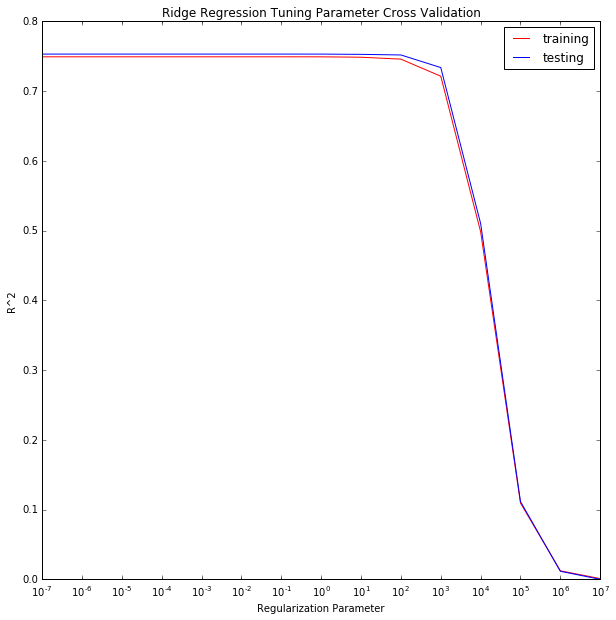

In [21]:
# tune parameter for ridge regression through cross validations
ridge_lasso_cv(x_train_scaled, y_train, 'ridge')

In [54]:
# fit and score ridge regression to predict price
ridge = Ridge(alpha = 10.0**0)
ridge.fit(x_train_scaled, y_train)
print 'Train Score: {0:.4f}'.format(ridge.score(x_train_scaled, y_train))
print 'Test Score: {0:.4f}'.format(ridge.score(x_test_scaled, y_test))

Train Score: 0.7477
Test Score: 0.6864


In [60]:
# write data to excel for tableau visualizations
model_data_to_excel(ridge, x_train_scaled, x_train, y_train, False, df_for_model, 'ridge_train_no_log')
model_data_to_excel(ridge, x_test_scaled, x_test, y_test, False, df_for_model, 'ridge_test_no_log')

*Ridge Regression - Log Price*

Regularization Parameter: 10^-7.0; Score:0.8579
Regularization Parameter: 10^-6.0; Score:0.8579
Regularization Parameter: 10^-5.0; Score:0.8579
Regularization Parameter: 10^-4.0; Score:0.8579
Regularization Parameter: 10^-3.0; Score:0.8579
Regularization Parameter: 10^-2.0; Score:0.8579
Regularization Parameter: 10^-1.0; Score:0.8579
Regularization Parameter: 10^0.0; Score:0.8578
Regularization Parameter: 10^1.0; Score:0.8555
Regularization Parameter: 10^2.0; Score:0.8429
Regularization Parameter: 10^3.0; Score:0.7860
Regularization Parameter: 10^4.0; Score:0.5619
Regularization Parameter: 10^5.0; Score:0.1371
Regularization Parameter: 10^6.0; Score:0.0117
Regularization Parameter: 10^7.0; Score:-0.0033


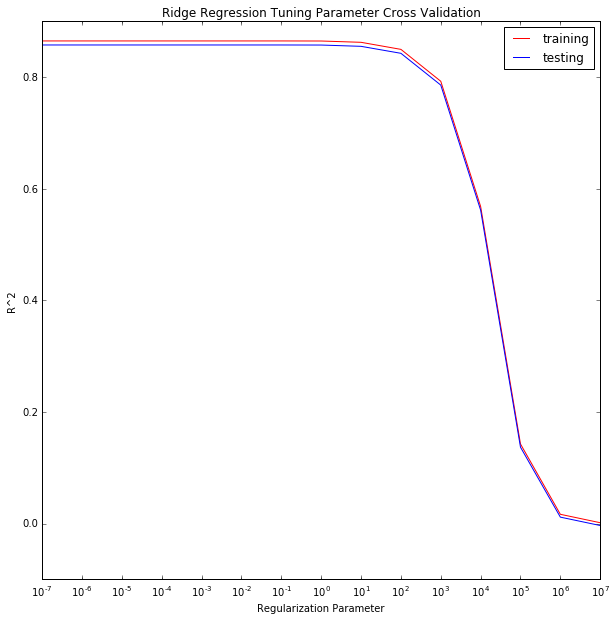

In [24]:
# tune parameter for ridge regression through cross validations
ridge_lasso_cv(x_train_scaled, y_train_log, 'ridge')

In [55]:
# fit and score ridge regression to predict log price
ridgeLog = Ridge(alpha = 10.0**-1)
ridgeLog.fit(x_train_scaled, y_train_log)

print 'Train Score: {0:.4f}'.format(r2_score(y_train, np.exp(ridgeLog.predict(x_train_scaled))))
print 'Test Score: {0:.4f}'.format(r2_score(y_test, np.exp(ridgeLog.predict(x_test_scaled))))

Train Score: 0.6721
Test Score: 0.6840


In [59]:
# write data to excel for tableau visualizations
model_data_to_excel(ridgeLog, x_train_scaled, x_train, y_train, True, df_for_model, 'ridge_train_log')
model_data_to_excel(ridgeLog, x_test_scaled, x_test, y_test, True, df_for_model, 'ridge_test_log')

# Lasso

*Lasso - Price*

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Regularization Parameter: 10^-7.0; Score:0.7315
Regularization Parameter: 10^-6.0; Score:0.7315
Regularization Parameter: 10^-5.0; Score:0.7315
Regularization Parameter: 10^-4.0; Score:0.7315
Regularization Parameter: 10^-3.0; Score:0.7315
Regularization Parameter: 10^-2.0; Score:0.7315
Regularization Parameter: 10^-1.0; Score:0.7315
Regularization Parameter: 10^0.0; Score:0.7316
Regularization Parameter: 10^1.0; Score:0.7308
Regularization Parameter: 10^2.0; Score:0.7280
Regularization Parameter: 10^3.0; Score:0.6923
Regularization Parameter: 10^4.0; Score:-0.0040
Regularization Parameter: 10^5.0; Score:-0.0040
Regularization Parameter: 10^6.0; Score:-0.0040
Regularization Parameter: 10^7.0; Score:-0.0040


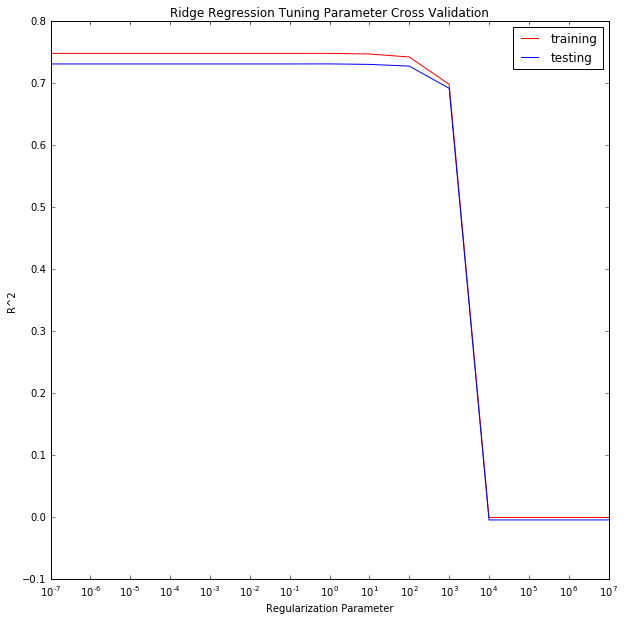

In [28]:
# tune parameter for lasso regression through cross validations
ridge_lasso_cv(x_train_scaled, y_train, 'lasso')

In [56]:
# fit and score lasso regression to predict price
lasso = Lasso(alpha = 10.0**0)
lasso.fit(x_train_scaled, y_train)
print 'Train Score: {0:.4f}'.format(lasso.score(x_train_scaled, y_train))
print 'Test Score: {0:.4f}'.format(lasso.score(x_test_scaled, y_test))

Train Score: 0.7477
Test Score: 0.6864


In [57]:
# iterate through predictors and print those whose coefficients are zeros
print 'Zero Coefficient Predictors:'
for i, coef in enumerate(lasso.coef_):
    if coef == 0:
        print df_for_model.columns.values[i + 1]

Zero Coefficient Predictors:
central_park_border_km
Brooklyn


In [58]:
# write data to excel for tableau visualizations
model_data_to_excel(lasso, x_train_scaled, x_train, y_train, False, df_for_model, 'lasso_train_no_log')
model_data_to_excel(lasso, x_test_scaled, x_test, y_test, False, df_for_model, 'lasso_test_no_log')

*Lasso - Log Price*

Regularization Parameter: 10^-7.0; Score:0.8612
Regularization Parameter: 10^-6.0; Score:0.8612
Regularization Parameter: 10^-5.0; Score:0.8612
Regularization Parameter: 10^-4.0; Score:0.8611
Regularization Parameter: 10^-3.0; Score:0.8593
Regularization Parameter: 10^-2.0; Score:0.8482
Regularization Parameter: 10^-1.0; Score:0.7419
Regularization Parameter: 10^0.0; Score:-0.0030
Regularization Parameter: 10^1.0; Score:-0.0030
Regularization Parameter: 10^2.0; Score:-0.0030
Regularization Parameter: 10^3.0; Score:-0.0030
Regularization Parameter: 10^4.0; Score:-0.0030
Regularization Parameter: 10^5.0; Score:-0.0030
Regularization Parameter: 10^6.0; Score:-0.0030
Regularization Parameter: 10^7.0; Score:-0.0030


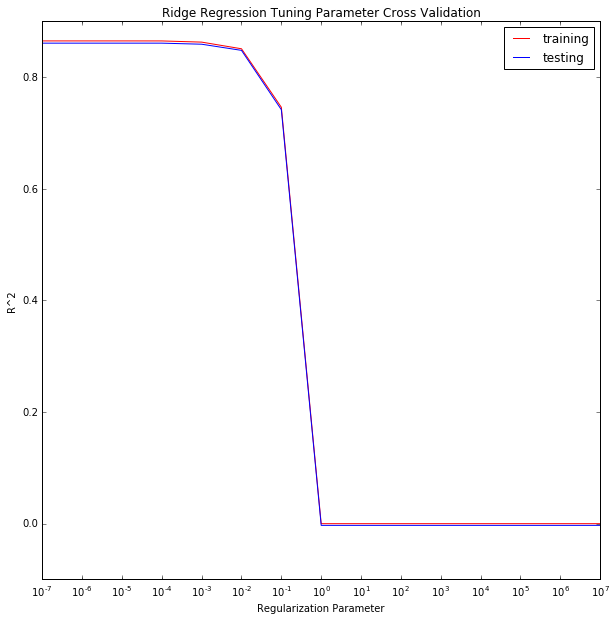

In [32]:
# tune parameter for lasso regression through cross validations
ridge_lasso_cv(x_train_scaled, y_train_log, 'lasso')

In [76]:
# fit and score lasso regression to predict log price
lassoLog = Lasso(alpha = 10.0**-5)
lassoLog.fit(x_train_scaled, y_train_log)

print 'Train Score: {0:.4f}'.format(r2_score(y_train, np.exp(lassoLog.predict(x_train_scaled))))
print 'Test Score: {0:.4f}'.format(r2_score(y_test, np.exp(lassoLog.predict(x_test_scaled))))

Train Score: 0.6721
Test Score: 0.6839


In [77]:
# iterate through predictors and print those whose coefficients are zeros
print 'Zero Coefficient Predictors:'
for i, coef in enumerate(lassoLog.coef_):
    if coef == 0:
        print df_for_model.columns.values[i + 1]

Zero Coefficient Predictors:


In [78]:
# write data to excel for tableau visualizations
model_data_to_excel(lassoLog, x_train_scaled, x_train, y_train, True, df_for_model, 'lasso_train_log')
model_data_to_excel(lassoLog, x_test_scaled, x_test,y_test, True, df_for_model, 'lasso_test_log')

# Boosting

*Boosting - Price*

In [38]:
# tune parameters for boosting through cross validation
boosting_cv(x_train, y_train)

Trees:10; Learning Rate:0.001; Score:0.6929
Trees:10; Learning Rate:0.01; Score:0.7058
Trees:10; Learning Rate:0.1; Score:0.7061
Trees:10; Learning Rate:0.5; Score:0.6860
Trees:10; Learning Rate:1; Score:0.6819
Trees:50; Learning Rate:0.001; Score:0.6878
Trees:50; Learning Rate:0.01; Score:0.6895
Trees:50; Learning Rate:0.1; Score:0.6781
Trees:50; Learning Rate:0.5; Score:0.6716
Trees:50; Learning Rate:1; Score:0.6472
Trees:100; Learning Rate:0.001; Score:0.6540
Trees:100; Learning Rate:0.01; Score:0.6601
Trees:100; Learning Rate:0.1; Score:0.6566
Trees:100; Learning Rate:0.5; Score:0.6382
Trees:100; Learning Rate:1; Score:0.6059
Trees:200; Learning Rate:0.001; Score:0.6132
Trees:200; Learning Rate:0.01; Score:0.6169
Trees:200; Learning Rate:0.1; Score:0.6183
Trees:200; Learning Rate:0.5; Score:0.6003
Trees:200; Learning Rate:1; Score:0.5691


In [62]:
# fit and score boosting to predict price
boosting = AdaBoostRegressor(n_estimators = 10, learning_rate = .1)
boosting.fit(x_train, y_train)
print 'Train Score: {0:.4f}'.format(boosting.score(x_train, y_train))
print 'Test Score: {0:.4f}'.format(boosting.score(x_test, y_test))

Train Score: 0.7879
Test Score: 0.6907


In [63]:
# write data to excel for tableau visualizations
model_data_to_excel(boosting, x_train, x_train, y_train, False, df_for_model, 'boosting_train_no_log')
model_data_to_excel(boosting, x_test, x_test, y_test, False, df_for_model, 'boosting_test_no_log')

*Boosting- Log Price*

In [41]:
# tune parameters for boosting through cross validation
boosting_cv(x_train, y_train_log)

Trees:10; Learning Rate:0.001; Score:0.7745
Trees:10; Learning Rate:0.01; Score:0.7742
Trees:10; Learning Rate:0.1; Score:0.7751
Trees:10; Learning Rate:0.5; Score:0.7821
Trees:10; Learning Rate:1; Score:0.7868
Trees:50; Learning Rate:0.001; Score:0.7845
Trees:50; Learning Rate:0.01; Score:0.7835
Trees:50; Learning Rate:0.1; Score:0.7870
Trees:50; Learning Rate:0.5; Score:0.7904
Trees:50; Learning Rate:1; Score:0.7925
Trees:100; Learning Rate:0.001; Score:0.7909
Trees:100; Learning Rate:0.01; Score:0.7904
Trees:100; Learning Rate:0.1; Score:0.7927
Trees:100; Learning Rate:0.5; Score:0.7939
Trees:100; Learning Rate:1; Score:0.7942
Trees:200; Learning Rate:0.001; Score:0.7930
Trees:200; Learning Rate:0.01; Score:0.7933
Trees:200; Learning Rate:0.1; Score:0.7950
Trees:200; Learning Rate:0.5; Score:0.7954
Trees:200; Learning Rate:1; Score:0.7953


In [64]:
# fit and score boosting to predict log price
boostingLog = AdaBoostRegressor(n_estimators = 200, learning_rate = 1)
boostingLog.fit(x_train, y_train_log)

print 'Train Score: {0:.4f}'.format(r2_score(y_train, np.exp(boostingLog.predict(x_train))))
print 'Test Score: {0:.4f}'.format(r2_score(y_test, np.exp(boostingLog.predict(x_test))))

Train Score: 0.8314
Test Score: 0.7492


In [65]:
# write data to excel for tableau visualizations
model_data_to_excel(boostingLog, x_train, x_train, y_train, True, df_for_model, 'boosting_train_log')
model_data_to_excel(boostingLog, x_test, x_test, y_test, True, df_for_model, 'boosting_test_log')

# Random Forest

*Random Forest - Price*

In [44]:
# tune parameters for random forest through cross validation
cv_scores = rf_cv(x_train, y_train)

Features:1; Score:0.7549
Features:2; Score:0.7801
Features:3; Score:0.7845
Features:4; Score:0.7849
Features:5; Score:0.7830
Features:6; Score:0.7801
Features:7; Score:0.7771
Features:8; Score:0.7755
Features:9; Score:0.7739
Features:10; Score:0.7722
Features:11; Score:0.7712
Features:12; Score:0.7691
Features:13; Score:0.7667
Features:14; Score:0.7687
Features:15; Score:0.7703
Features:16; Score:0.7691
Features:17; Score:0.7671
Features:18; Score:0.7635
Features:19; Score:0.7640
Features:20; Score:0.7639
Features:21; Score:0.7609
Features:22; Score:0.7576
Features:23; Score:0.7532


In [66]:
# fit and score random forest to predict price
rf = RandomForestRegressor(max_features = 4, n_estimators = 500)
rf.fit(x_train, y_train)
print 'Train Score: {0:.4f}'.format(rf.score(x_train, y_train))
print 'Test Score: {0:.4f}'.format(rf.score(x_test, y_test))

Train Score: 0.9729
Test Score: 0.8220


In [67]:
# write data to excel for tableau visualizations
model_data_to_excel(rf, x_train, x_train, y_train, False, df_for_model, 'rf_train_no_log')
model_data_to_excel(rf, x_test, x_test, y_test, False, df_for_model, 'rf_test_no_log')

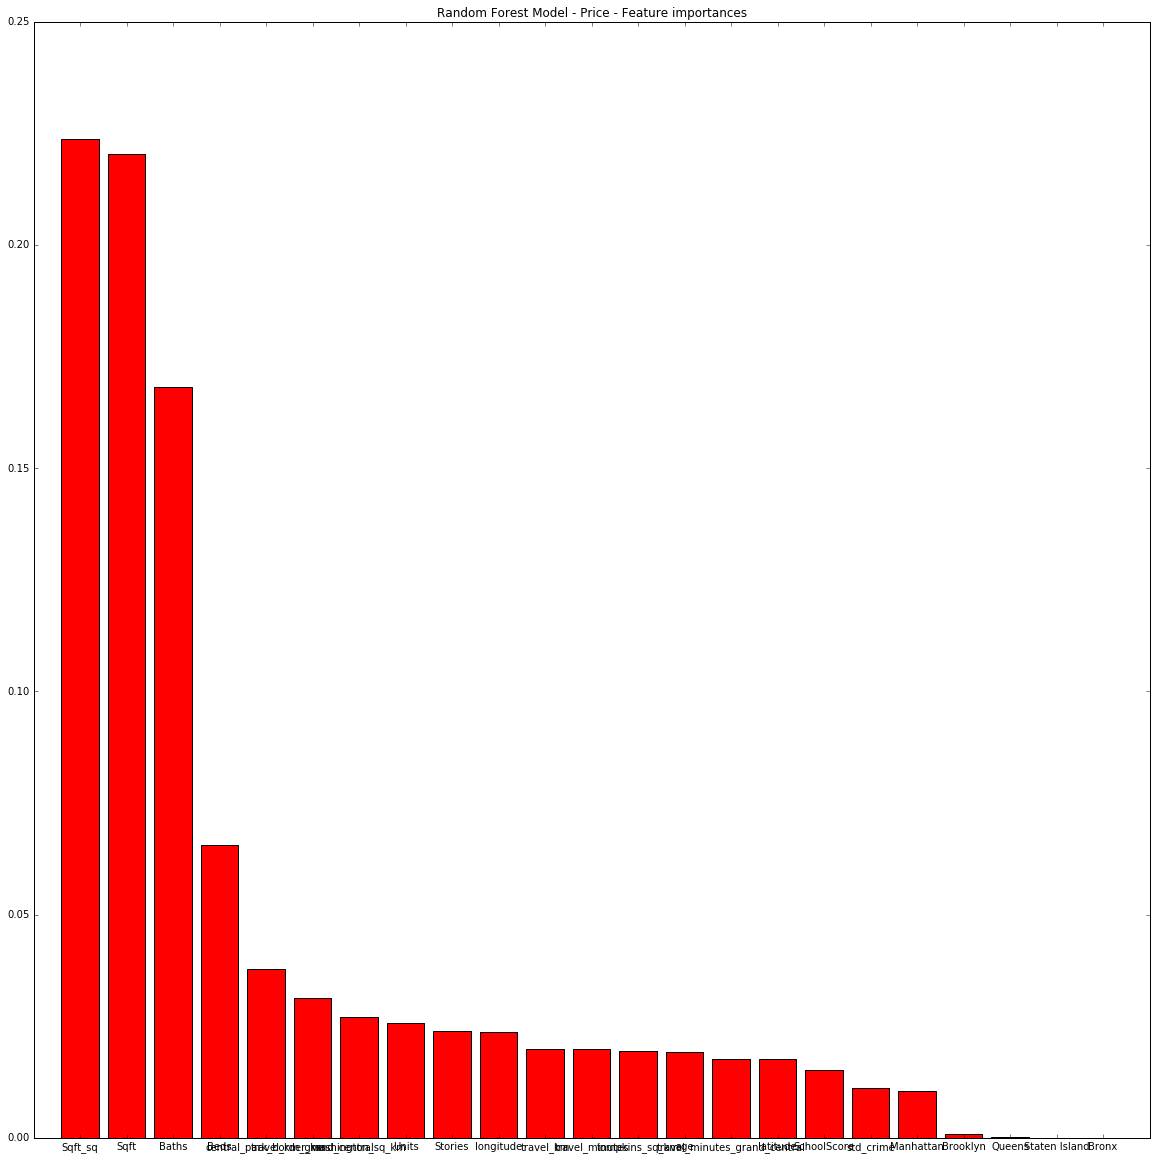

In [74]:
# get feature importance scores in the random forest model
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# get the predictor names of the predictors ranked by importance
predictor_names = df_for_model.ix[:, 1:].columns.values
predictor_names = [predictor_names[i] for i in indices]

# Plot the feature importances of the forest
plt.figure(figsize=(20, 20))
plt.title("Random Forest Model - Price - Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(x.shape[1]), predictor_names)
plt.xlim([-1, x.shape[1]])
plt.show()

In [75]:
# store the feature importances in excel for plotting in tableau
variable_importance = pd.DataFrame(predictor_names, columns = ['predictors'])    
variable_importance['importance'] = importances[indices]
variable_importance.to_excel('rent_visualization_data/rf_variable_importance_no_log.xlsx')

*Random Forest - Log Price*

In [49]:
# tune parameters for random forest through cross validation
cv_scores = rf_cv(x_train, y_train_log)

Features:1; Score:0.9015
Features:2; Score:0.9107
Features:3; Score:0.9131
Features:4; Score:0.9135
Features:5; Score:0.9121
Features:6; Score:0.9115
Features:7; Score:0.9101
Features:8; Score:0.9097
Features:9; Score:0.9096
Features:10; Score:0.9086
Features:11; Score:0.9086
Features:12; Score:0.9078
Features:13; Score:0.9075
Features:14; Score:0.9077
Features:15; Score:0.9072
Features:16; Score:0.9067
Features:17; Score:0.9061
Features:18; Score:0.9059
Features:19; Score:0.9051
Features:20; Score:0.9056
Features:21; Score:0.9047
Features:22; Score:0.9044
Features:23; Score:0.9038


In [69]:
# fit and score random forest to predict log price
rfLog = RandomForestRegressor(max_features = 4, n_estimators = 500)
rfLog.fit(x_train, y_train_log)

print 'Train Score: {0:.4f}'.format(r2_score(y_train, np.exp(rfLog.predict(x_train))))
print 'Test Score: {0:.4f}'.format(r2_score(y_test, np.exp(rfLog.predict(x_test))))

Train Score: 0.9433
Test Score: 0.7830


In [70]:
# write data to excel for tableau visualizations
model_data_to_excel(rfLog, x_train, x_train, y_train, True, df_for_model, 'rf_train_log')
model_data_to_excel(rfLog, x_test, x_test, y_test, True, df_for_model, 'rf_test_log')

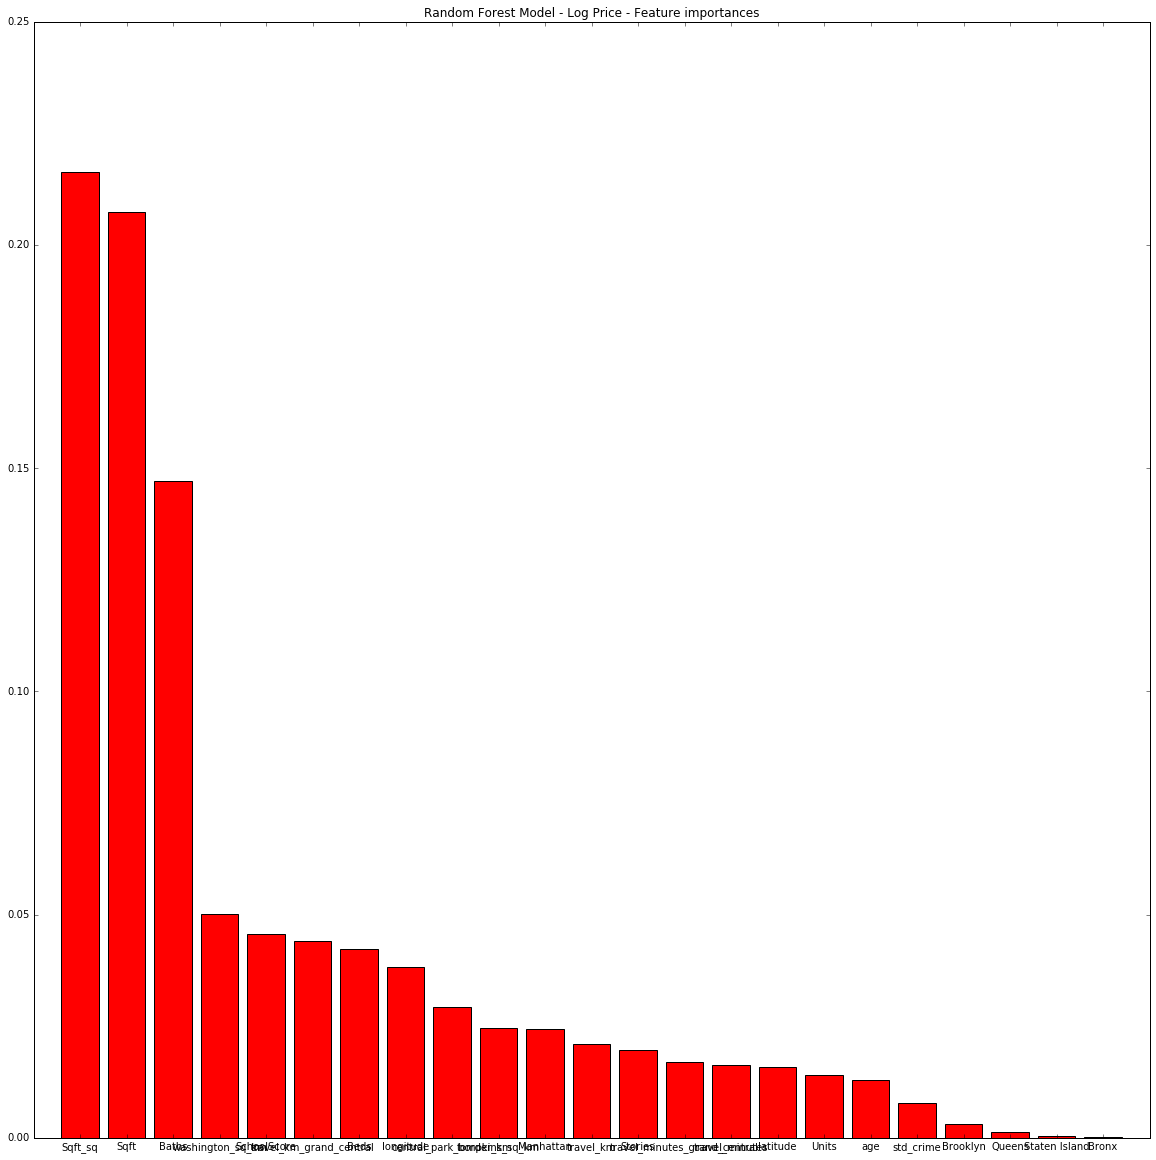

In [71]:
# get feature importance scores in the random forest model
importances = rfLog.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfLog.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# get the predictor names of the predictors ranked by importance
predictor_names = df_for_model.ix[:, 1:].columns.values
predictor_names = [predictor_names[i] for i in indices]

# Plot the feature importances of the forest
plt.figure(figsize=(20, 20))
plt.title("Random Forest Model - Log Price - Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(x.shape[1]), predictor_names)
plt.xlim([-1, x.shape[1]])
plt.show()

In [72]:
# store the feature importances in excel for plotting in tableau
variable_importance = pd.DataFrame(predictor_names, columns = ['predictors'])    
variable_importance['importance'] = importances[indices]
variable_importance.to_excel('rent_visualization_data/rf_variable_importance_log.xlsx')